In [ ]:
import casatasks
from casatasks import *
# from casatools import *
import casatools
import os
import matplotlib.pyplot as plt

# from calibration_script_v3 import *
from casaplotms import plotms
from casaviewer.imview import imview
import glob
import numpy as np
msmd = casatools.msmetadata()
ms = casatools.ms()
tb = casatools.table()
import matplotlib as mpl

In [ ]:
import sys
path_to_morphen = '../../../../'
sys.path.append(f"{path_to_morphen}/morphen/morphen/")
import mlibs as mlibs


                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
       Morphen                |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

In [5]:
def get_phase_centre_s(vis):
    
    from astropy.coordinates import SkyCoord
    import astropy.units as u

    msmd.open(vis)
    ra_radians = msmd.phasecenter()['m0']['value']
    dec_radians = msmd.phasecenter()['m1']['value']
    msmd.close()
    # Convert to SkyCoord object
    coord = SkyCoord(ra=ra_radians*u.radian, dec=dec_radians*u.radian, frame='icrs')

    # Format the output using 'hmsdms'
    formatted_coord = coord.to_string('hmsdms')
    formatted_ra, formatted_dec = formatted_coord.split()
    
    formatted_ra_hms = formatted_ra.replace('h', ':').replace('m', ':').replace('s', '')
    formatted_dec_dms = formatted_dec.replace('d', '.').replace('m', '.').replace('s', '')

    formatted_output = "J2000 {} {}".format(formatted_ra_hms, formatted_dec_dms)

    # print(formatted_output)
    return(formatted_output)


def get_phase_centre(vis):
    from astropy.coordinates import SkyCoord
    import astropy.units as u

    msmd.open(vis)
    ra_radians = msmd.phasecenter()['m0']['value']
    dec_radians = msmd.phasecenter()['m1']['value']
    msmd.close()
    # Convert to SkyCoord object
    coord = SkyCoord(ra=ra_radians * u.radian, dec=dec_radians * u.radian, frame='icrs')

    # Format the output using 'hmsdms'
    formatted_coord = coord.to_string('hmsdms')
    formatted_ra, formatted_dec = formatted_coord.split()

    formatted_ra_hms = formatted_ra.replace('h', ':').replace('m', ':').replace('s', '')
    formatted_dec_dms = formatted_dec.replace('d', '.').replace('m', '.').replace('s', '')

    formatted_output = "J2000 {} {}".format(formatted_ra_hms, formatted_dec_dms)
    frame = "J2000"
    coordinates = "{} {}".format(formatted_ra_hms, formatted_dec_dms)
    # print(formatted_output)
    return (formatted_output,frame,coordinates)


## L Band

In [ ]:
# IMAGE GREAT AREA OF THE FOV
n_subimages = 4
vis = '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/UGC04881_A_L_sf.ms'
path = f"{os.path.dirname(vis)}/"
name = os.path.splitext(vis)[0]
phase_shift_vis = name + '_ps.ms'
uv_sub_vis = name + '_uvsub.ms'
_,frame,or_phc = get_phase_centre(vis)

In [8]:
or_phc

'09:15:55.48999977 +44.19.58.0000047'

In [9]:
phase_centres = ['J2000 09:14:57.207 +44.33.09.462',
                 'J2000 09:16:19.298 +44.31.34.192',
                 'J2000 09:15:29.588 +44.16.44.748',
                 'J2000 09:15:38.408 +44.10.52.235',
                 'J2000 09:15:52.210 +44.10.16.233',
                 'J2000 09:16:30.765 +44.10.53.934',
                 'J2000 09:17:19.498 +44.08.39.227'
                ]

In [10]:
k = 1
# casatasks.phaseshift(vis=vis,
#                      outputvis=uv_sub_vis.replace(f'.ms',f'_tmp.ms'),
#                      phasecenter=phase_centre)
for phase_centre in phase_centres:
    if k == 1:
        casatasks.phaseshift(vis=vis,
                         outputvis=uv_sub_vis.replace(f'.ms',f'_tmp_{k}.ms'),
                         phasecenter=phase_centre)
    else:
        os.system(f"rm -r {uv_sub_vis.replace(f'.ms',f'_tmp_{k-1}.ms')}")
        
        casatasks.phaseshift(vis=uv_sub_vis.replace(f'.ms',f'_tmp_split_{k-1}.ms'),
                         outputvis=uv_sub_vis.replace(f'.ms',f'_tmp_{k}.ms'),
                         phasecenter=phase_centre)
        os.system(f"rm -r {uv_sub_vis.replace(f'.ms',f'_tmp_split_{k-1}.ms')}")

    for ROBUST in [0.0]:
        # prefix = 'final_image_for_spidx_cb_bs_0.05asec'
        prefix = f"uvsub_{k}_nc{n_subimages}"
        image_list,image_statistics,Omaj = \
            mlibs.run_wsclean(uv_sub_vis.replace(f'.ms',f'_tmp_{k}.ms'), 
                        robust=ROBUST,
                        imsize=int(256), 
                        imsizey=int(256), 
                        # opt_args= "' -no-mf-weighting '",
                        # opt_args= "' -circular-beam -beam-size 0.05asec '",
                        cell='0.2asec',
                        savemodel = True,
                        base_name=prefix,
                        nsigma_automask='7.0',
                        nsigma_autothreshold='1.5',
                        quiet=True,
                        # shift=None,
                        nc=n_subimages,
                        with_multiscale=True,
                        # scales='0,40,120,240',
                        scales='None',
                        datacolumn='DATA',
                        uvtaper=[''],
                        niter=100000,
                        calculate_subband_fluxes = False
                             )
    casatasks.uvsub(vis=uv_sub_vis.replace(f'.ms',f'_tmp_{k}.ms'))
    
    casatasks.split(vis=uv_sub_vis.replace(f'.ms',f'_tmp_{k}.ms'),
                    outputvis=uv_sub_vis.replace(f'.ms',f'_tmp_split_{k}.ms'),
                    datacolumn='corrected')

    k=k+1

 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.0
Using mtmfs method.
uvsub_1_nc4_UGC04881_A_L_sf_uvsub_tmp_1_256x256_0.2asec_multiscale__r0.0
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec --nv --bind /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/:/mnt /nvme1/scratch/lucatelli/apps/wsclean3.4-idg-everybeam-eMERLIN_portable.sif mpirun -np 8 wsclean-mp -name /mnt/uvsub_1_nc4_UGC04881_A_L_sf_uvsub_tmp_1_256x256_0.2asec_multiscale__r0.0 -size 256 256 -scale 0.2asec  -mgain 0.5 -gain 0.1 -nmiter 500  -niter 100000 -weight briggs 0.0  -auto-mask 7.0  -auto-threshold 1.5  -multiscale  -multiscale-scale-bias 0.75 -multiscale-gain 0.05  -multiscale-max-scales 6   -deconvolution-threads 16 -j 16 -parallel-reordering 16 -weighting-rank-filter 3 -weighting-rank-filter-size 128 -gridder wgridder -wstack-nwlayers-factor 3 -wgridder-accuracy 1e-7 -no-mf-weighting -channels-out 4 -join-channels -negative -fit-spe

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 2, PID 10926 on canopus.jb.man.ac.uk
Node 3, PID 10927 on canopus.jb.man.ac.uk
Node 5, PID 10929 on canopus.jb.man.ac.uk
Node 0, PID 10924 on canopus.jb.man.ac.uk
Node 1, PID 10925 on canopus.jb.man.ac.uk
Node 4, PID 10928 on canopus.jb.man.ac.uk
Node 6, PID 10930 on canopus.jb.man.ac.uk
Node 7, PID 10931 on canopus.jb.man.ac.uk
2025-Feb-15 15:23:00.247645 Process 4 finished.
2025-Feb-15 15:23:00.247631 Process 0 finished.
2025-Feb-15 15:23:00.247678 Process 7 finished.
2025-Feb-15 15:23:00.247687 Process 6 finished.
2025-Feb-15 15:23:00.247649 Process 5 finished.
2025-Feb-15 15:23:00.247828 Process 2 finished.
2025-Feb-15 15:23:00.247843 Process 3 finished.
2025-Feb-15 15:23:00.247901 Process 1 finished.
 ++==>> Exec time cleaning = 126.2 s
 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.0
Using mtmfs method.
uvsub_2_nc4_UGC04881_A_L_sf_uvsub_tmp_2_256x256_0.2asec_multiscale__r0.0
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec --nv --b

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 1, PID 46939 on canopus.jb.man.ac.uk
Node 2, PID 46940 on canopus.jb.man.ac.uk
Node 3, PID 46941 on canopus.jb.man.ac.uk
Node 4, PID 46942 on canopus.jb.man.ac.uk
Node 5, PID 46943 on canopus.jb.man.ac.uk
Node 6, PID 46944 on canopus.jb.man.ac.uk
Node 7, PID 46954 on canopus.jb.man.ac.uk
Node 0, PID 46938 on canopus.jb.man.ac.uk
2025-Feb-15 15:27:01.511838 Process 4 finished.
2025-Feb-15 15:27:01.511831 Process 5 finished.
2025-Feb-15 15:27:01.511814 Process 0 finished.
2025-Feb-15 15:27:01.511867 Process 7 finished.
2025-Feb-15 15:27:01.511868 Process 6 finished.
2025-Feb-15 15:27:01.511960 Process 1 finished.
2025-Feb-15 15:27:01.511984 Process 2 finished.
2025-Feb-15 15:27:01.511984 Process 3 finished.
 ++==>> Exec time cleaning = 101.8 s
 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.0
Using mtmfs method.
uvsub_3_nc4_UGC04881_A_L_sf_uvsub_tmp_3_256x256_0.2asec_multiscale__r0.0
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec --nv --b

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 0, PID 88517 on canopus.jb.man.ac.uk
Node 1, PID 88518 on canopus.jb.man.ac.uk
Node 2, PID 88519 on canopus.jb.man.ac.uk
Node 3, PID 88520 on canopus.jb.man.ac.uk
Node 4, PID 88521 on canopus.jb.man.ac.uk
Node 5, PID 88522 on canopus.jb.man.ac.uk
Node 6, PID 88523 on canopus.jb.man.ac.uk
Node 7, PID 88525 on canopus.jb.man.ac.uk
2025-Feb-15 15:32:08.297635 Process 0 finished.
2025-Feb-15 15:32:08.297648 Process 5 finished.
2025-Feb-15 15:32:08.297684 Process 6 finished.
2025-Feb-15 15:32:08.297675 Process 4 finished.
2025-Feb-15 15:32:08.297701 Process 7 finished.
2025-Feb-15 15:32:08.297776 Process 1 finished.
2025-Feb-15 15:32:08.297849 Process 2 finished.
2025-Feb-15 15:32:08.297991 Process 3 finished.
 ++==>> Exec time cleaning = 167.8 s
 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.0
Using mtmfs method.
uvsub_4_nc4_UGC04881_A_L_sf_uvsub_tmp_4_256x256_0.2asec_multiscale__r0.0
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec --nv --b

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 0, PID 60318 on canopus.jb.man.ac.uk
Node 1, PID 60319 on canopus.jb.man.ac.uk
Node 2, PID 60320 on canopus.jb.man.ac.uk
Node 3, PID 60321 on canopus.jb.man.ac.uk
Node 4, PID 60322 on canopus.jb.man.ac.uk
Node 5, PID 60323 on canopus.jb.man.ac.uk
Node 6, PID 60324 on canopus.jb.man.ac.uk
Node 7, PID 60325 on canopus.jb.man.ac.uk
2025-Feb-15 15:36:04.673263 Process 0 finished.
2025-Feb-15 15:36:04.673298 Process 5 finished.
2025-Feb-15 15:36:04.673280 Process 4 finished.
2025-Feb-15 15:36:04.673312 Process 6 finished.
2025-Feb-15 15:36:04.673315 Process 7 finished.
2025-Feb-15 15:36:04.673389 Process 1 finished.
2025-Feb-15 15:36:04.673441 Process 2 finished.
2025-Feb-15 15:36:04.673461 Process 3 finished.
 ++==>> Exec time cleaning = 112.4 s
 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.0
Using mtmfs method.
uvsub_5_nc4_UGC04881_A_L_sf_uvsub_tmp_5_256x256_0.2asec_multiscale__r0.0
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec --nv --b

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 1, PID 105538 on canopus.jb.man.ac.uk
Node 2, PID 105539 on canopus.jb.man.ac.uk
Node 3, PID 105540 on canopus.jb.man.ac.uk
Node 5, PID 105542 on canopus.jb.man.ac.uk
Node 6, PID 105543 on canopus.jb.man.ac.uk
Node 7, PID 105544 on canopus.jb.man.ac.uk
Node 0, PID 105537 on canopus.jb.man.ac.uk
Node 4, PID 105541 on canopus.jb.man.ac.uk
2025-Feb-15 15:41:01.415403 Process 0 finished.
2025-Feb-15 15:41:01.415411 Process 4 finished.
2025-Feb-15 15:41:01.415418 Process 5 finished.
2025-Feb-15 15:41:01.415460 Process 6 finished.
2025-Feb-15 15:41:01.415480 Process 7 finished.
2025-Feb-15 15:41:01.415547 Process 1 finished.
2025-Feb-15 15:41:01.415612 Process 2 finished.
2025-Feb-15 15:41:01.415884 Process 3 finished.
 ++==>> Exec time cleaning = 144.3 s
 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.0
Using mtmfs method.
uvsub_6_nc4_UGC04881_A_L_sf_uvsub_tmp_6_256x256_0.2asec_multiscale__r0.0
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec 

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 2, PID 17123 on canopus.jb.man.ac.uk
Node 6, PID 17127 on canopus.jb.man.ac.uk
Node 0, PID 17121 on canopus.jb.man.ac.uk
Node 1, PID 17122 on canopus.jb.man.ac.uk
Node 3, PID 17124 on canopus.jb.man.ac.uk
Node 4, PID 17125 on canopus.jb.man.ac.uk
Node 5, PID 17126 on canopus.jb.man.ac.uk
Node 7, PID 17128 on canopus.jb.man.ac.uk
2025-Feb-15 15:46:15.309225 Process 5 finished.
2025-Feb-15 15:46:15.309194 Process 0 finished.
2025-Feb-15 15:46:15.309264 Process 7 finished.
2025-Feb-15 15:46:15.309250 Process 6 finished.
2025-Feb-15 15:46:15.309238 Process 4 finished.
2025-Feb-15 15:46:15.309341 Process 1 finished.
2025-Feb-15 15:46:15.309432 Process 3 finished.
2025-Feb-15 15:46:15.309386 Process 2 finished.
 ++==>> Exec time cleaning = 154.5 s
 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.0
Using mtmfs method.
uvsub_7_nc4_UGC04881_A_L_sf_uvsub_tmp_7_256x256_0.2asec_multiscale__r0.0
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec --nv --b

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 6, PID 56880 on canopus.jb.man.ac.uk
Node 7, PID 56881 on canopus.jb.man.ac.uk
Node 1, PID 56875 on canopus.jb.man.ac.uk
Node 2, PID 56876 on canopus.jb.man.ac.uk
Node 3, PID 56877 on canopus.jb.man.ac.uk
Node 0, PID 56822 on canopus.jb.man.ac.uk
Node 4, PID 56878 on canopus.jb.man.ac.uk
Node 5, PID 56879 on canopus.jb.man.ac.uk
2025-Feb-15 15:51:29.760812 Process 0 finished.
2025-Feb-15 15:51:29.760852 Process 5 finished.
2025-Feb-15 15:51:29.760843 Process 4 finished.
2025-Feb-15 15:51:29.760901 Process 6 finished.
2025-Feb-15 15:51:29.760898 Process 7 finished.
2025-Feb-15 15:51:29.760971 Process 1 finished.
2025-Feb-15 15:51:29.761097 Process 2 finished.
2025-Feb-15 15:51:29.761332 Process 3 finished.
 ++==>> Exec time cleaning = 143.5 s


In [11]:
os.system(f"rm -r {uv_sub_vis.replace(f'.ms',f'_tmp_{k-1}.ms')}")
casatasks.phaseshift(vis=uv_sub_vis.replace(f'.ms',f'_tmp_split_{k-1}.ms'),
                 outputvis=uv_sub_vis,
                 phasecenter=f"{frame} {or_phc}")
os.system(f"rm -r {uv_sub_vis.replace(f'.ms',f'_tmp_split_{k-1}.ms')}")

0

## Compare science image before and after uvsub of bright source

 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.5
Using mtmfs method.
final_image_nc4_nomfwt_UGC04881_A_L_sf_1024x1024_0.2asec_multiscale__r0.5
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec --nv --bind /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/:/mnt /nvme1/scratch/lucatelli/apps/wsclean3.4-idg-everybeam-eMERLIN_portable.sif mpirun -np 8 wsclean-mp -name /mnt/final_image_nc4_nomfwt_UGC04881_A_L_sf_1024x1024_0.2asec_multiscale__r0.5 -size 1024 1024 -scale 0.2asec  -mgain 0.5 -gain 0.1 -nmiter 500  -niter 100000 -weight briggs 0.5  -auto-mask 3.0  -auto-threshold 1.0  -multiscale  -multiscale-scale-bias 0.75 -multiscale-gain 0.05  -multiscale-max-scales 6   -deconvolution-threads 16 -j 16 -parallel-reordering 16 -weighting-rank-filter 3 -weighting-rank-filter-size 128 -gridder wgridder -wstack-nwlayers-factor 3 -wgridder-accuracy 1e-7 -no-mf-weighting -channels-out 4 -join-channels -negative -fit

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 0, PID 93584 on canopus.jb.man.ac.uk
Node 1, PID 93585 on canopus.jb.man.ac.uk
Node 4, PID 93592 on canopus.jb.man.ac.uk
Node 7, PID 93595 on canopus.jb.man.ac.uk
Node 2, PID 93590 on canopus.jb.man.ac.uk
Node 3, PID 93591 on canopus.jb.man.ac.uk
Node 5, PID 93593 on canopus.jb.man.ac.uk
Node 6, PID 93594 on canopus.jb.man.ac.uk
2025-Feb-15 15:59:42.248310 Process 5 finished.
2025-Feb-15 15:59:42.248314 Process 4 finished.
2025-Feb-15 15:59:42.248299 Process 0 finished.
2025-Feb-15 15:59:42.248318 Process 6 finished.
2025-Feb-15 15:59:42.248338 Process 7 finished.
2025-Feb-15 15:59:42.248448 Process 1 finished.
2025-Feb-15 15:59:42.248478 Process 2 finished.
2025-Feb-15 15:59:42.248501 Process 3 finished.
 ++==>> Exec time cleaning = 301.6 s


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


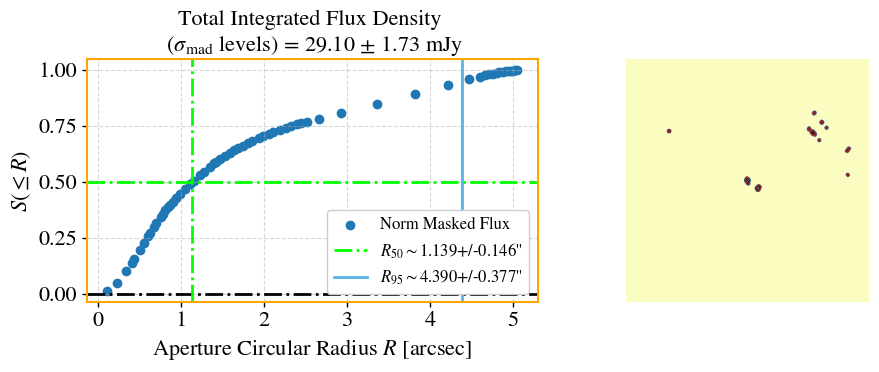

Using residual map as RMS estimator: /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_L_sf_1024x1024_0.2asec_multiscale__r0.5-MFS-residual.fits
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_L_sf_1024x1024_0.2asec_multiscale__r0.5-0000-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_L_sf_1024x1024_0.2asec_multiscale__r0.5-0000-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 37.58 +/- 5.12 mJy
Fractional error = 0.14
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 37.58 +/- 1.94 mJy
Fractional error = 0.05
-------------------

/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


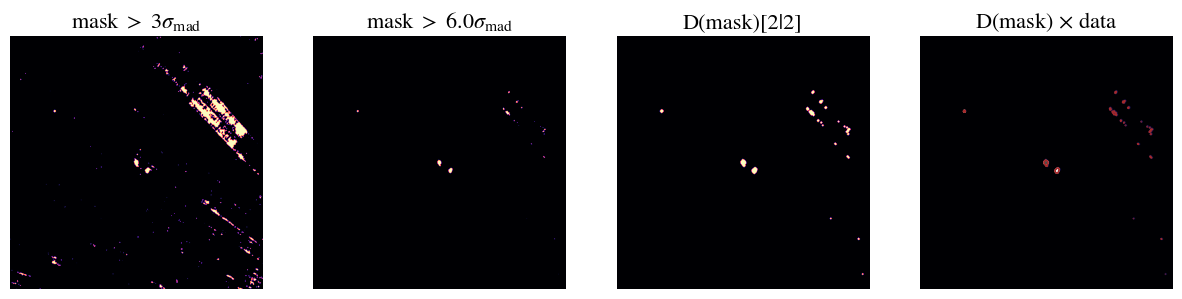

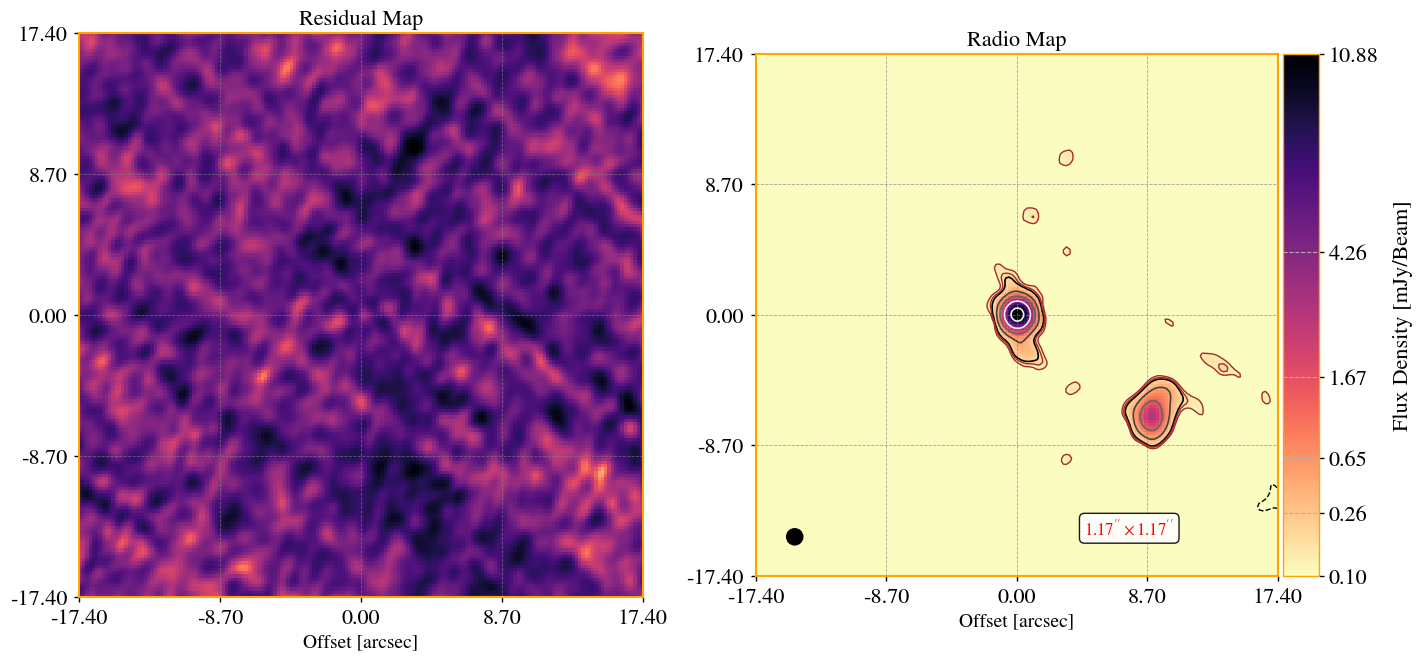

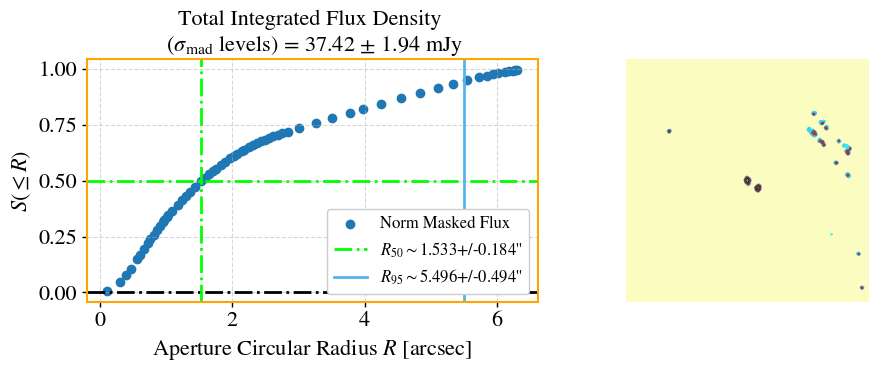

Flux density =  0.03757662003917354
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_L_sf_1024x1024_0.2asec_multiscale__r0.5-0001-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_L_sf_1024x1024_0.2asec_multiscale__r0.5-0001-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 36.24 +/- 3.63 mJy
Fractional error = 0.10
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 36.24 +/- 2.02 mJy
Fractional error = 0.06
-----------------------------------------------------------------


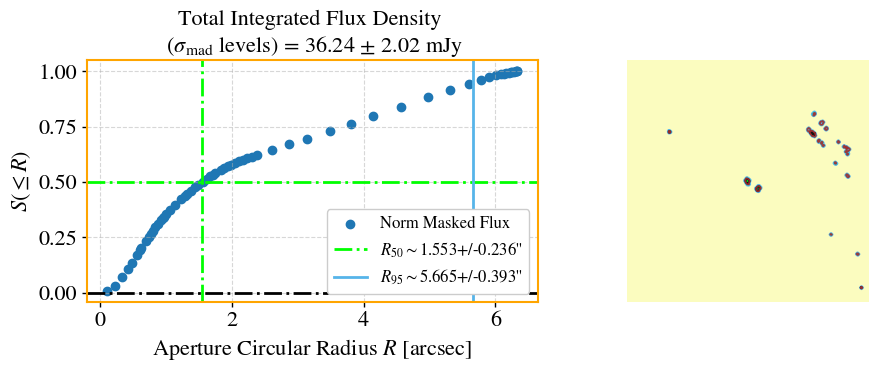

Flux density =  0.036239073811369836
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_L_sf_1024x1024_0.2asec_multiscale__r0.5-0002-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_L_sf_1024x1024_0.2asec_multiscale__r0.5-0002-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 32.31 +/- 7.74 mJy
Fractional error = 0.24
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 32.31 +/- 2.57 mJy
Fractional error = 0.08
-----------------------------------------------------------------


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


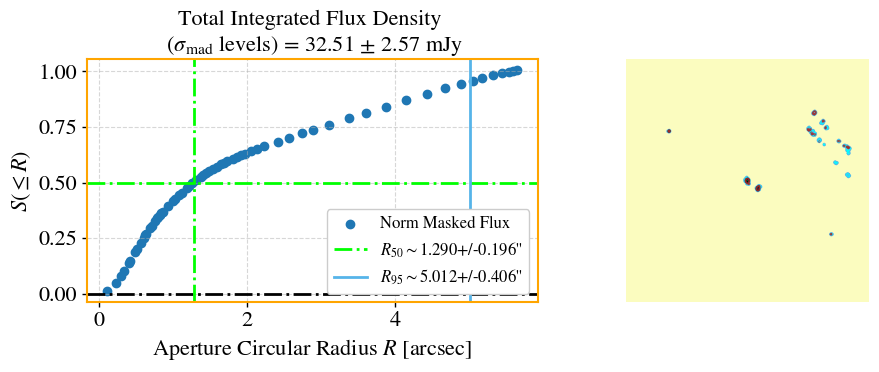

Flux density =  0.032308062286239954
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_L_sf_1024x1024_0.2asec_multiscale__r0.5-0003-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_L_sf_1024x1024_0.2asec_multiscale__r0.5-0003-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 31.91 +/- 8.48 mJy
Fractional error = 0.27
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 31.91 +/- 4.33 mJy
Fractional error = 0.14
-----------------------------------------------------------------


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


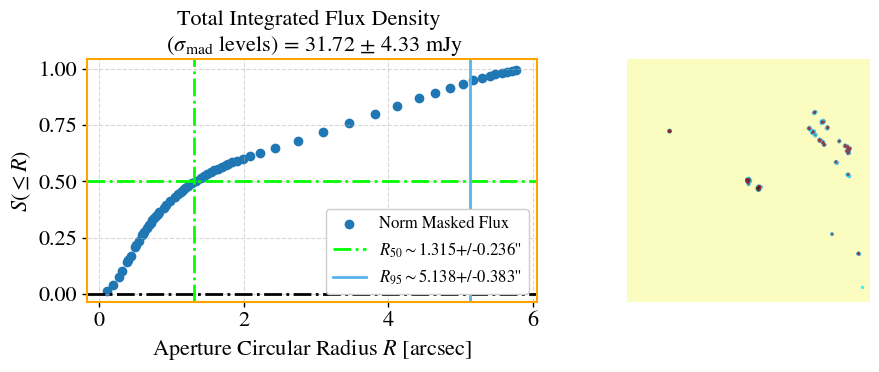

Flux density =  0.03190942867646121
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.1901e+00                                    1.64e+03    
       1              2         6.7954e+00      3.95e-01       4.58e+01       1.01e+01    
       2              3         6.6370e+00      1.58e-01       8.54e-01       1.03e+01    
       3              4         6.3016e+00      3.35e-01       1.69e+00       1.09e+01    
       4              5         5.5342e+00      7.67e-01       3.31e+00       1.24e+01    
       5              6         3.6639e+00      1.87e+00       6.25e+00       9.54e+00    
       6              7         5.7717e-01      3.09e+00       1.17e+01       3.31e+03    
       7              9         2.6703e-01      3.10e-01       3.43e+00       9.76e+00    
       8             10         9.6330e-02      1.71e-01       7.55e-01       4.57e+00    
       9             11         5.7120e-02      3.92e-

100%|██████████| 5000/5000 [00:17<00:00, 279.59it/s]


{'A1': {'best': 34.21691153920807, 'lower_bound': 32.80526483416643, 'upper_bound': 35.63816434369627, 'lower': 1.4116467050416404, 'upper': 1.4212528044881978}, 'alpha': {'best': -0.3415097154699724, 'lower_bound': -0.5436273145418555, 'upper_bound': -0.14893475292297415, 'lower': 0.20211759907188315, 'upper': 0.19257496254699824}}
(100000, 2)
++==>> Parameter Results (MCMC sampling).
++==>> Parameter Results (from least-squares fit).
[[Variables]]
    A1:     34.1978578 +/- 0.50759078 (1.48%) (init = 34.19786)
    alpha: -0.34689565 +/- 0.07388275 (21.30%) (init = -0.3468956)
---------------------------------------------
------------ RESTORING BEAM SIZE ------------
                1.171 arcec            
---------------------------------------------


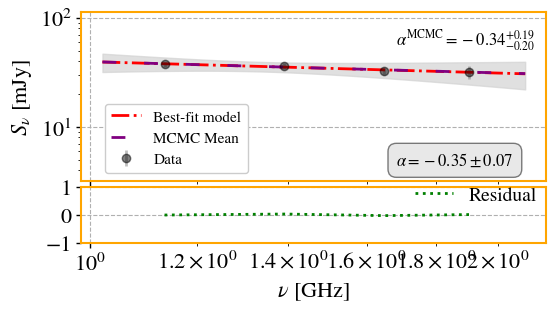

<Figure size 600x400 with 0 Axes>

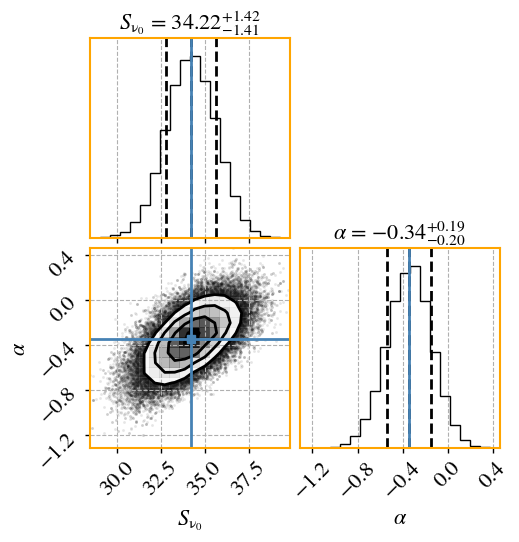

In [12]:
for ROBUST in [0.5]:
    # prefix = 'final_image_for_spidx_cb_bs_0.05asec'
    prefix = f"final_image_nc{n_subimages}_nomfwt"
    image_list,image_statistics,Omaj = \
        mlibs.run_wsclean(vis, robust=ROBUST,
                    imsize=int(1024*1), 
                    imsizey=int(1024*1), 
                    # opt_args= "' -no-mf-weighting '",
                    # opt_args= "' -circular-beam -beam-size 0.05asec '",
                    cell='0.2asec',
                    savemodel = False,
                    base_name=prefix,
                    nsigma_automask='3.0',
                    nsigma_autothreshold='1.0',
                    quiet=True,
                    nc=n_subimages,
                    with_multiscale=True,
                    # scales='0,40,120,240',
                    scales='None',
                    datacolumn='DATA',
                    uvtaper=[''],
                    niter=100000)

 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.5
Using mtmfs method.
uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_L_sf_uvsub_1024x1024_0.2asec_multiscale__r0.5
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec --nv --bind /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/:/mnt /nvme1/scratch/lucatelli/apps/wsclean3.4-idg-everybeam-eMERLIN_portable.sif mpirun -np 8 wsclean-mp -name /mnt/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_L_sf_uvsub_1024x1024_0.2asec_multiscale__r0.5 -size 1024 1024 -scale 0.2asec  -mgain 0.5 -gain 0.1 -nmiter 500  -niter 100000 -weight briggs 0.5  -auto-mask 3.0  -auto-threshold 1.0  -multiscale  -multiscale-scale-bias 0.75 -multiscale-gain 0.05  -multiscale-max-scales 6   -deconvolution-threads 16 -j 16 -parallel-reordering 16 -weighting-rank-filter 3 -weighting-rank-filter-size 128 -gridder wgridder -wstack-nwlayers-factor 3 -wgridder-accuracy 1e-7 -no-mf-weighting -channels

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 5, PID 71462 on canopus.jb.man.ac.uk
Node 6, PID 71463 on canopus.jb.man.ac.uk
Node 7, PID 71464 on canopus.jb.man.ac.uk
Node 0, PID 71457 on canopus.jb.man.ac.uk
Node 1, PID 71458 on canopus.jb.man.ac.uk
Node 2, PID 71459 on canopus.jb.man.ac.uk
Node 3, PID 71460 on canopus.jb.man.ac.uk
Node 4, PID 71461 on canopus.jb.man.ac.uk
2025-Feb-15 16:03:41.064914 Process 5 finished.
2025-Feb-15 16:03:41.064911 Process 4 finished.
2025-Feb-15 16:03:41.064899 Process 0 finished.
2025-Feb-15 16:03:41.064925 Process 6 finished.
2025-Feb-15 16:03:41.064958 Process 7 finished.
2025-Feb-15 16:03:41.065049 Process 1 finished.
2025-Feb-15 16:03:41.065077 Process 2 finished.
2025-Feb-15 16:03:41.065099 Process 3 finished.
 ++==>> Exec time cleaning = 185.2 s


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


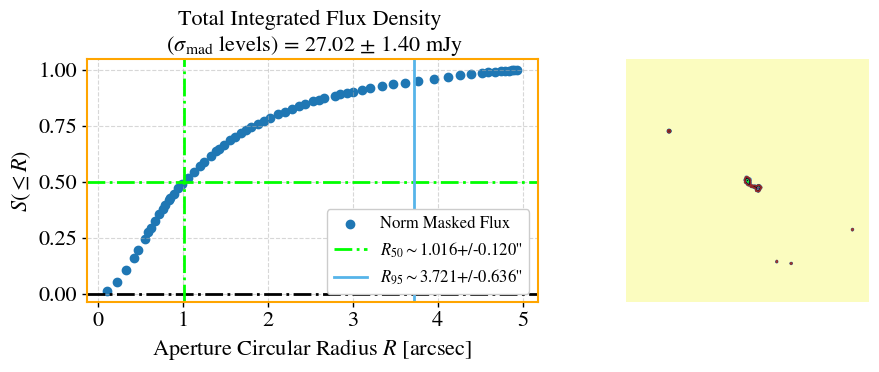

Using residual map as RMS estimator: /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_L_sf_uvsub_1024x1024_0.2asec_multiscale__r0.5-MFS-residual.fits
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_L_sf_uvsub_1024x1024_0.2asec_multiscale__r0.5-0000-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_L_sf_uvsub_1024x1024_0.2asec_multiscale__r0.5-0000-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 32.78 +/- 2.00 mJy
Fractional error = 0.06
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 32.78 +/

/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


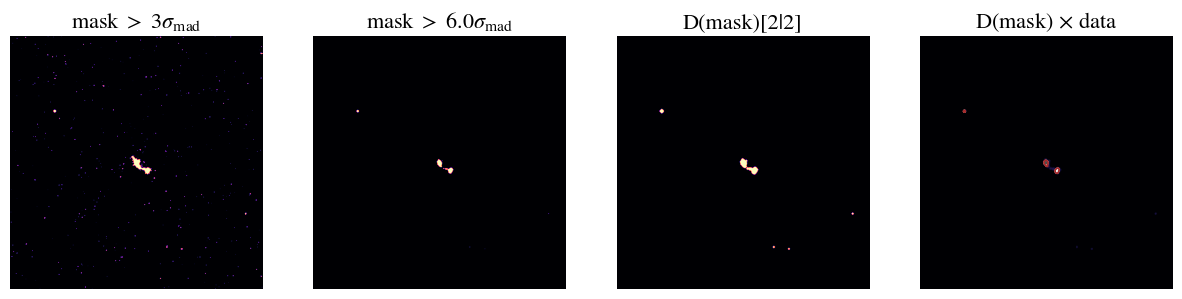

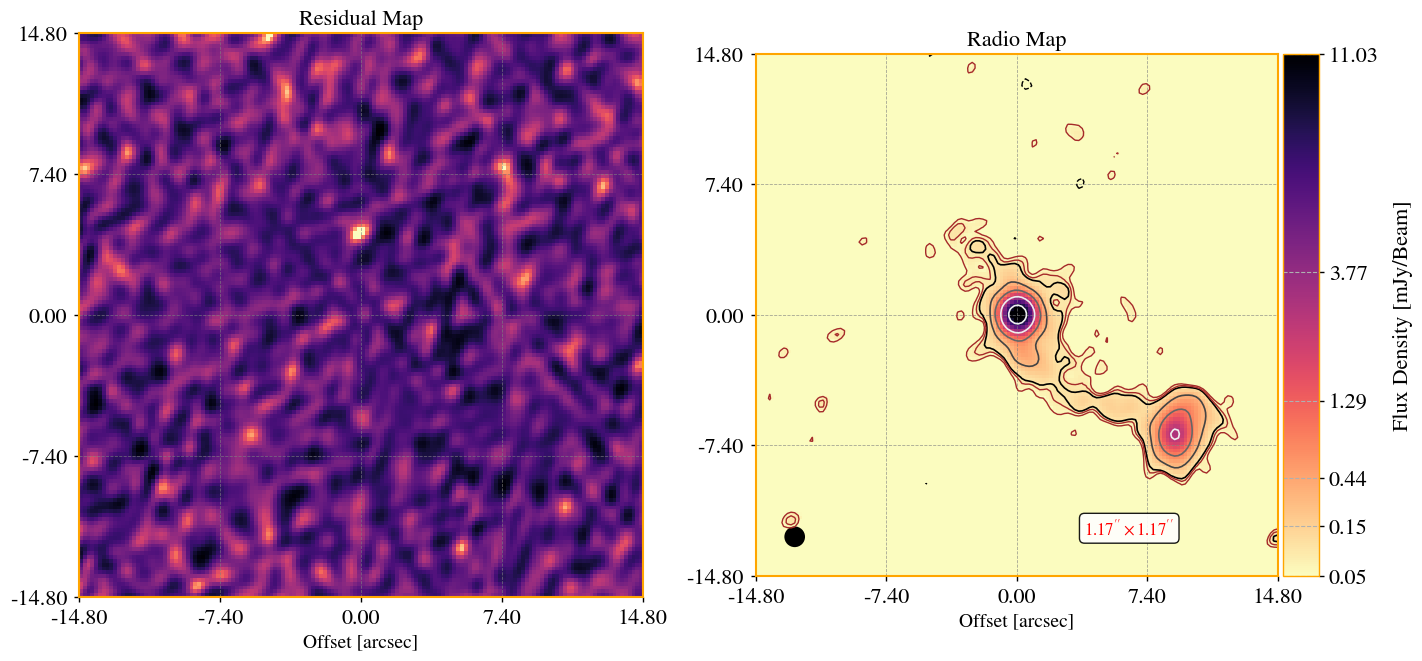

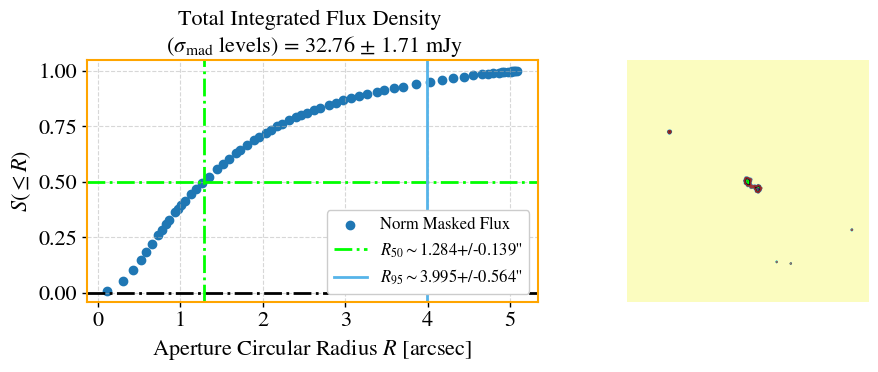

Flux density =  0.032779484597928156
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_L_sf_uvsub_1024x1024_0.2asec_multiscale__r0.5-0003-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_L_sf_uvsub_1024x1024_0.2asec_multiscale__r0.5-0003-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 23.67 +/- 3.35 mJy
Fractional error = 0.14
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 23.67 +/- 1.29 mJy
Fractional error = 0.05
-----------------------------------------------------------------


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


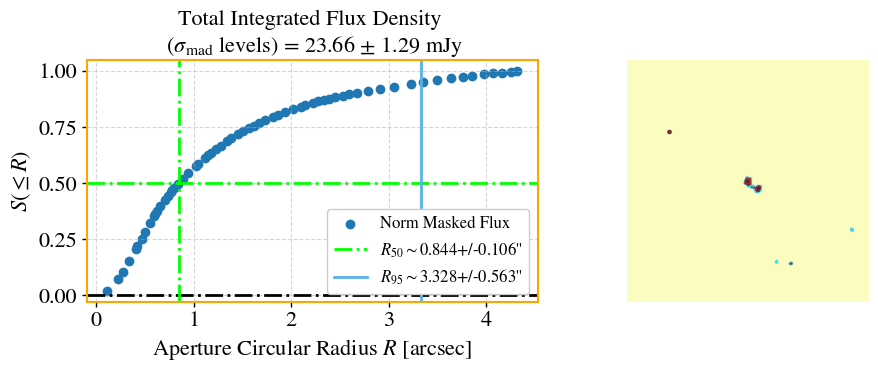

Flux density =  0.023667254472841966
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_L_sf_uvsub_1024x1024_0.2asec_multiscale__r0.5-0002-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_L_sf_uvsub_1024x1024_0.2asec_multiscale__r0.5-0002-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 25.74 +/- 2.54 mJy
Fractional error = 0.10
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 25.74 +/- 1.33 mJy
Fractional error = 0.05
-----------------------------------------------------------------


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


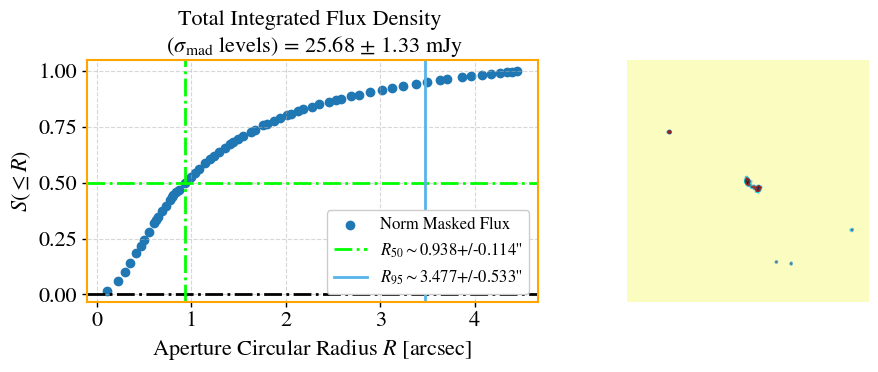

Flux density =  0.025740718155099904
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_L_sf_uvsub_1024x1024_0.2asec_multiscale__r0.5-0001-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_L_sf_uvsub_1024x1024_0.2asec_multiscale__r0.5-0001-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 28.71 +/- 1.36 mJy
Fractional error = 0.05
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 28.71 +/- 1.45 mJy
Fractional error = 0.05
-----------------------------------------------------------------


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


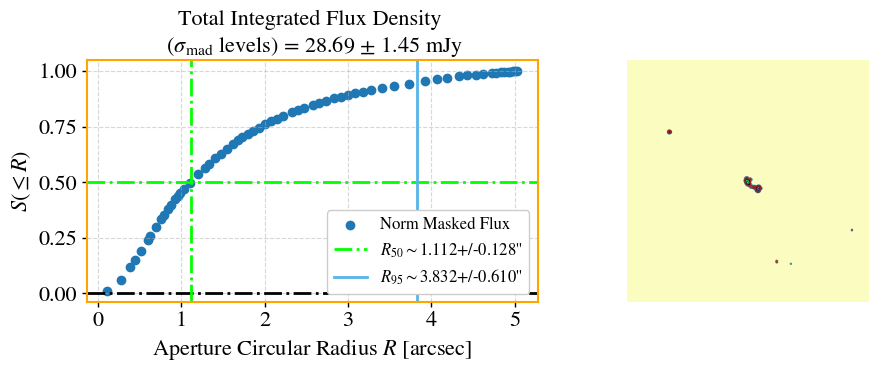

Flux density =  0.02871458471007667
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.4990e+00                                    2.19e+03    
       1              3         1.8905e+00      3.61e+00       1.15e+01       4.39e+03    
       2              5         8.5499e-02      1.81e+00       5.72e+00       4.76e+00    
       3              6         5.7529e-03      7.97e-02       1.28e-01       1.16e+00    
       4              7         5.7262e-04      5.18e-03       7.26e-02       3.88e-03    
       5              8         5.7255e-04      7.85e-08       5.07e-04       5.53e-06    
       6              9         5.7255e-04      1.23e-13       3.87e-07       1.03e-08    
       7             12         5.7255e-04      5.42e-18       2.54e-11       1.24e-08    
       8             13         5.7255e-04      6.29e-18       5.07e-11       1.08e-08    
       9             20         5.7255e-04      0.00e+

100%|██████████| 5000/5000 [00:14<00:00, 340.59it/s]


{'A1': {'best': 27.208416868951723, 'lower_bound': 26.702984040831637, 'upper_bound': 27.706166631063738, 'lower': 0.5054328281200853, 'upper': 0.49774976211201505}, 'alpha': {'best': -0.6322141602039553, 'lower_bound': -0.7244838245296404, 'upper_bound': -0.5417971659253781, 'lower': 0.09226966432568517, 'upper': 0.09041699427857719}}
(100000, 2)
++==>> Parameter Results (MCMC sampling).
++==>> Parameter Results (from least-squares fit).
[[Variables]]
    A1:     27.2003738 +/- 0.05569466 (0.20%) (init = 27.20037)
    alpha: -0.63543581 +/- 0.01001960 (1.58%) (init = -0.6354358)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, alpha) = 0.305
---------------------------------------------
------------ RESTORING BEAM SIZE ------------
                1.171 arcec            
---------------------------------------------


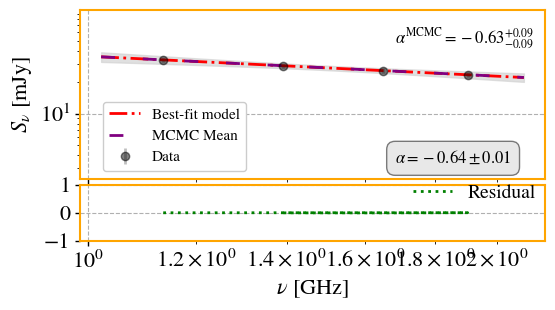

<Figure size 600x400 with 0 Axes>

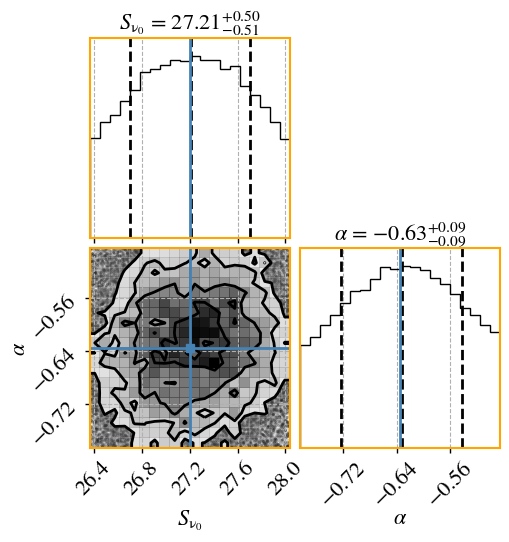

In [13]:
for ROBUST in [0.5]:
    # prefix = 'final_image_for_spidx_cb_bs_0.05asec'
    prefix = f"uvsub_clean_image_final_nc{n_subimages}_nomfwt"
    image_list,image_statistics,Omaj = \
        mlibs.run_wsclean(uv_sub_vis, robust=ROBUST,
                    imsize=int(1024*1), 
                    imsizey=int(1024*1), 
                    # opt_args= "' -no-mf-weighting '",
                    # opt_args= "' -circular-beam -beam-size 0.05asec '",
                    cell='0.2asec',
                    savemodel = False,
                    base_name=prefix,
                    nsigma_automask='3.0',
                    nsigma_autothreshold='1.0',
                    quiet=True,
                    nc=n_subimages,
                    with_multiscale=True,
                    # scales='0,40,120,240',
                    scales='None',
                    datacolumn='DATA',
                    uvtaper=[''],
                    niter=100000)

In [14]:
# plotms(vis=uv_sub_vis,xaxis='uvwave',yaxis='amp',avgchannel='9999',avgtime='9999',correlation='RR',avgantenna=True)

In [15]:
plotms(vis=uv_sub_vis,xaxis='uvwave',yaxis='amp',avgchannel='9999',avgtime='9999',
       correlation='RR',avgantenna=False,
       customsymbol=True,symbolsize=1,plotindex=0, clearplots=True,
       symbolcolor='black', symbolshape='circle'
       )
plotms(vis=vis,xaxis='uvwave',yaxis='amp',avgchannel='9999',avgtime='9999',
       correlation='RR',avgantenna=False,
       customsymbol=True,symbolsize=1,plotindex=1, clearplots=False,
       symbolcolor='purple', symbolshape='diamond'
       )

E0215 16:04:30.507203038  130487 call.cc:896]                Invalid entry in accept encoding metadata: ' deflate'. Ignoring.
E0215 16:04:30.507252968  130487 call.cc:896]                Invalid entry in accept encoding metadata: ' gzip'. Ignoring.


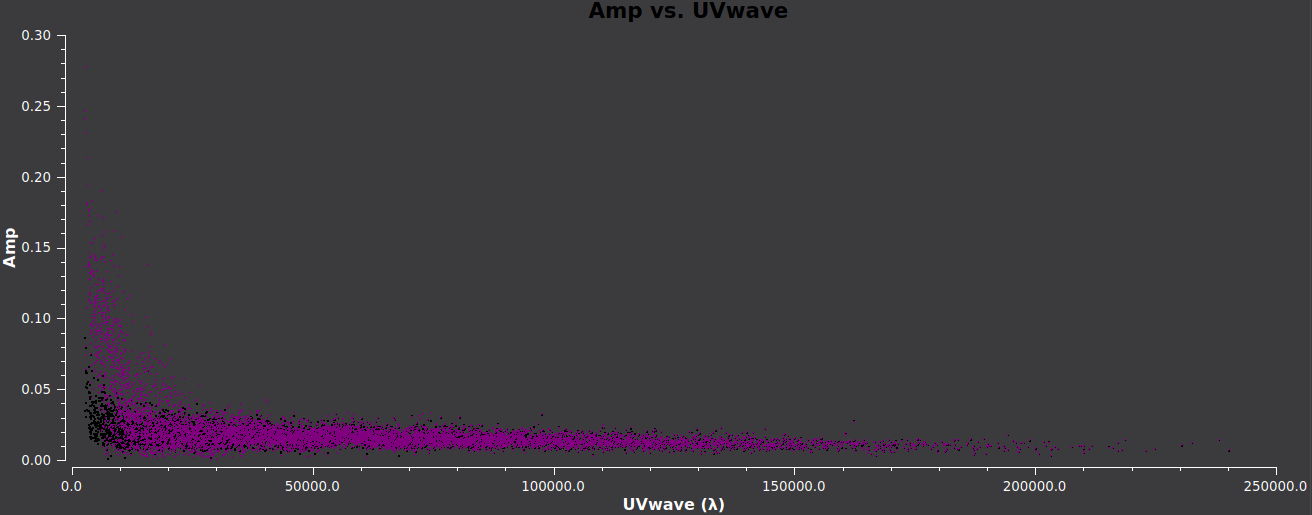

## S Band

In [ ]:
# IMAGE GREAT AREA OF THE FOV
n_subimages = 4
vis = '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/UGC04881_A_S_sf.ms'
path = f"{os.path.dirname(vis)}/"
name = os.path.splitext(vis)[0]
phase_shift_vis = name + '_ps.ms'
uv_sub_vis = name + '_uvsub.ms'
_,frame,or_phc = get_phase_centre(vis)

2025-02-15 16:04:31	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 0 is smaller than specified chanbin 9999
2025-02-15 16:04:31	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 0
2025-02-15 16:04:31	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 1 is smaller than specified chanbin 9999
2025-02-15 16:04:31	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 1
2025-02-15 16:04:31	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 2 is smaller than specified chanbin 9999
2025-02-15 16:04:31	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 2
2025-02-15 16:04:31	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 3 is smaller than specified chanbin 9999
2025-02-15 16:04:31	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SP

In [18]:
or_phc

'09:15:55.48999977 +44.19.58.0000047'

In [19]:
phase_centres = [
                 'J2000 09:15:29.582 +44.16.44.686',
                ]

In [20]:
k = 1
# casatasks.phaseshift(vis=vis,
#                      outputvis=uv_sub_vis.replace(f'.ms',f'_tmp.ms'),
#                      phasecenter=phase_centre)
for phase_centre in phase_centres:
    if k == 1:
        casatasks.phaseshift(vis=vis,
                         outputvis=uv_sub_vis.replace(f'.ms',f'_tmp_{k}.ms'),
                         phasecenter=phase_centre)
    else:
        os.system(f"rm -r {uv_sub_vis.replace(f'.ms',f'_tmp_{k-1}.ms')}")
        
        casatasks.phaseshift(vis=uv_sub_vis.replace(f'.ms',f'_tmp_split_{k-1}.ms'),
                         outputvis=uv_sub_vis.replace(f'.ms',f'_tmp_{k}.ms'),
                         phasecenter=phase_centre)
        os.system(f"rm -r {uv_sub_vis.replace(f'.ms',f'_tmp_split_{k-1}.ms')}")

    for ROBUST in [0.0]:
        # prefix = 'final_image_for_spidx_cb_bs_0.05asec'
        prefix = f"uvsub_{k}_nc{n_subimages}"
        image_list,image_statistics,Omaj = \
            mlibs.run_wsclean(uv_sub_vis.replace(f'.ms',f'_tmp_{k}.ms'), 
                        robust=ROBUST,
                        imsize=int(256*3), 
                        imsizey=int(256*3), 
                        # opt_args= "' -no-mf-weighting '",
                        # opt_args= "' -circular-beam -beam-size 0.05asec '",
                        cell='0.1asec',
                        savemodel = True,
                        base_name=prefix,
                        nsigma_automask='7.0',
                        nsigma_autothreshold='1.5',
                        quiet=True,
                        # shift=None,
                        nc=n_subimages,
                        with_multiscale=True,
                        # scales='0,40,120,240',
                        scales='None',
                        datacolumn='DATA',
                        uvtaper=[''],
                        niter=100000,
                        calculate_subband_fluxes = False
                             )
    casatasks.uvsub(vis=uv_sub_vis.replace(f'.ms',f'_tmp_{k}.ms'))
    
    casatasks.split(vis=uv_sub_vis.replace(f'.ms',f'_tmp_{k}.ms'),
                    outputvis=uv_sub_vis.replace(f'.ms',f'_tmp_split_{k}.ms'),
                    datacolumn='corrected')

    k=k+1

2025-02-15 16:05:17	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 0 is smaller than specified chanbin 9999
2025-02-15 16:05:17	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 0
2025-02-15 16:05:17	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 1 is smaller than specified chanbin 9999
2025-02-15 16:05:17	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 1
2025-02-15 16:05:17	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 2 is smaller than specified chanbin 9999
2025-02-15 16:05:17	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 2
2025-02-15 16:05:17	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 3 is smaller than specified chanbin 9999
2025-02-15 16:05:17	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SP

 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.0
Using mtmfs method.
uvsub_1_nc4_UGC04881_A_S_sf_uvsub_tmp_1_768x768_0.1asec_multiscale__r0.0
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec --nv --bind /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/:/mnt /nvme1/scratch/lucatelli/apps/wsclean3.4-idg-everybeam-eMERLIN_portable.sif mpirun -np 8 wsclean-mp -name /mnt/uvsub_1_nc4_UGC04881_A_S_sf_uvsub_tmp_1_768x768_0.1asec_multiscale__r0.0 -size 768 768 -scale 0.1asec  -mgain 0.5 -gain 0.1 -nmiter 500  -niter 100000 -weight briggs 0.0  -auto-mask 7.0  -auto-threshold 1.5  -multiscale  -multiscale-scale-bias 0.75 -multiscale-gain 0.05  -multiscale-max-scales 6   -deconvolution-threads 16 -j 16 -parallel-reordering 16 -weighting-rank-filter 3 -weighting-rank-filter-size 128 -gridder wgridder -wstack-nwlayers-factor 3 -wgridder-accuracy 1e-7 -no-mf-weighting -channels-out 4 -join-channels -negative -fit-spectral-po

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 7, PID 10588 on canopus.jb.man.ac.uk
Node 0, PID 10581 on canopus.jb.man.ac.uk
Node 1, PID 10582 on canopus.jb.man.ac.uk
Node 4, PID 10585 on canopus.jb.man.ac.uk
Node 5, PID 10586 on canopus.jb.man.ac.uk
Node 6, PID 10587 on canopus.jb.man.ac.uk
Node 2, PID 10583 on canopus.jb.man.ac.uk
Node 3, PID 10584 on canopus.jb.man.ac.uk
2025-Feb-15 16:08:04.413805 Process 0 finished.
2025-Feb-15 16:08:04.413819 Process 4 finished.
2025-Feb-15 16:08:04.413858 Process 7 finished.
2025-Feb-15 16:08:04.413845 Process 6 finished.
2025-Feb-15 16:08:04.413823 Process 5 finished.
2025-Feb-15 16:08:04.413944 Process 1 finished.
2025-Feb-15 16:08:04.413975 Process 2 finished.
2025-Feb-15 16:08:04.413996 Process 3 finished.
 ++==>> Exec time cleaning = 116.1 s


In [21]:
os.system(f"rm -r {uv_sub_vis.replace(f'.ms',f'_tmp_{k-1}.ms')}")
casatasks.phaseshift(vis=uv_sub_vis.replace(f'.ms',f'_tmp_split_{k-1}.ms'),
                 outputvis=uv_sub_vis,
                 phasecenter=f"{frame} {or_phc}")
os.system(f"rm -r {uv_sub_vis.replace(f'.ms',f'_tmp_split_{k-1}.ms')}")

0

## Compare science image before and after uvsub of bright source

 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.5
Using mtmfs method.
final_image_nc4_nomfwt_UGC04881_A_S_sf_1024x1024_0.1asec_multiscale__r0.5
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec --nv --bind /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/:/mnt /nvme1/scratch/lucatelli/apps/wsclean3.4-idg-everybeam-eMERLIN_portable.sif mpirun -np 8 wsclean-mp -name /mnt/final_image_nc4_nomfwt_UGC04881_A_S_sf_1024x1024_0.1asec_multiscale__r0.5 -size 1024 1024 -scale 0.1asec  -mgain 0.5 -gain 0.1 -nmiter 500  -niter 100000 -weight briggs 0.5  -auto-mask 3.0  -auto-threshold 1.0  -multiscale  -multiscale-scale-bias 0.75 -multiscale-gain 0.05  -multiscale-max-scales 6   -deconvolution-threads 16 -j 16 -parallel-reordering 16 -weighting-rank-filter 3 -weighting-rank-filter-size 128 -gridder wgridder -wstack-nwlayers-factor 3 -wgridder-accuracy 1e-7 -no-mf-weighting -channels-out 4 -join-channels -negative -fit-spectra

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 5, PID 41345 on canopus.jb.man.ac.uk
Node 6, PID 41346 on canopus.jb.man.ac.uk
Node 3, PID 41343 on canopus.jb.man.ac.uk
Node 4, PID 41344 on canopus.jb.man.ac.uk
Node 7, PID 41347 on canopus.jb.man.ac.uk
Node 0, PID 41340 on canopus.jb.man.ac.uk
Node 1, PID 41341 on canopus.jb.man.ac.uk
Node 2, PID 41342 on canopus.jb.man.ac.uk
2025-Feb-15 16:56:35.334451 Process 0 finished.
2025-Feb-15 16:56:35.334465 Process 5 finished.
2025-Feb-15 16:56:35.334466 Process 4 finished.
2025-Feb-15 16:56:35.334485 Process 6 finished.
2025-Feb-15 16:56:35.334476 Process 7 finished.
2025-Feb-15 16:56:35.334592 Process 1 finished.
2025-Feb-15 16:56:35.334651 Process 2 finished.
2025-Feb-15 16:56:35.334680 Process 3 finished.
 ++==>> Exec time cleaning = 139.1 s


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


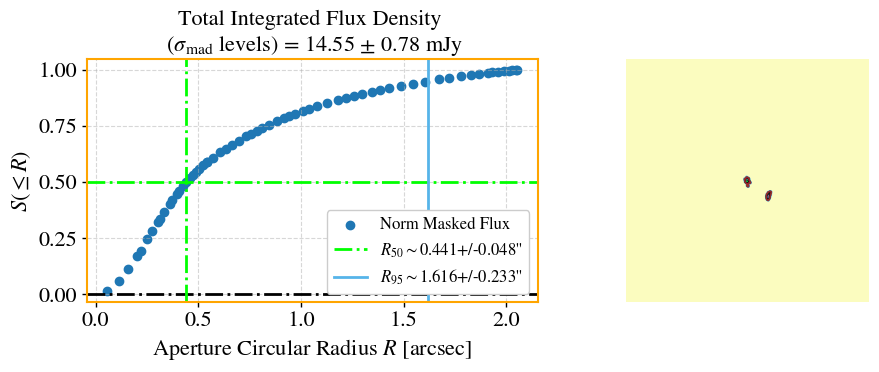

Using residual map as RMS estimator: /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_S_sf_1024x1024_0.1asec_multiscale__r0.5-MFS-residual.fits
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_S_sf_1024x1024_0.1asec_multiscale__r0.5-0002-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_S_sf_1024x1024_0.1asec_multiscale__r0.5-0002-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 14.52 +/- 0.98 mJy
Fractional error = 0.07
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 14.52 +/- 0.79 mJy
Fractional error = 0.05
-------------------------------------------

/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


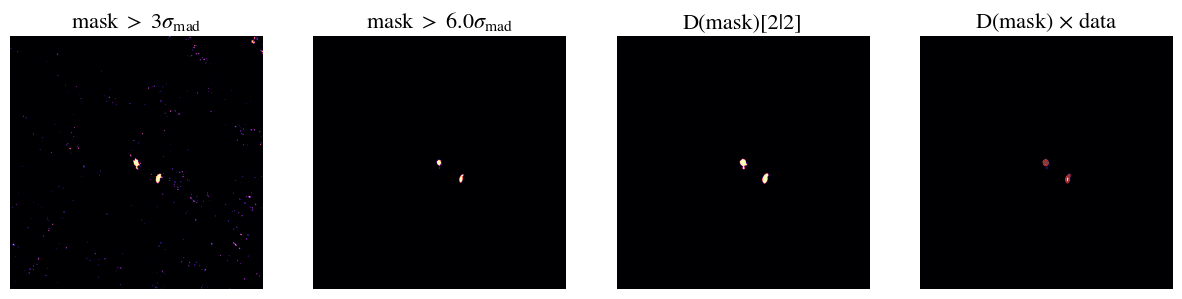

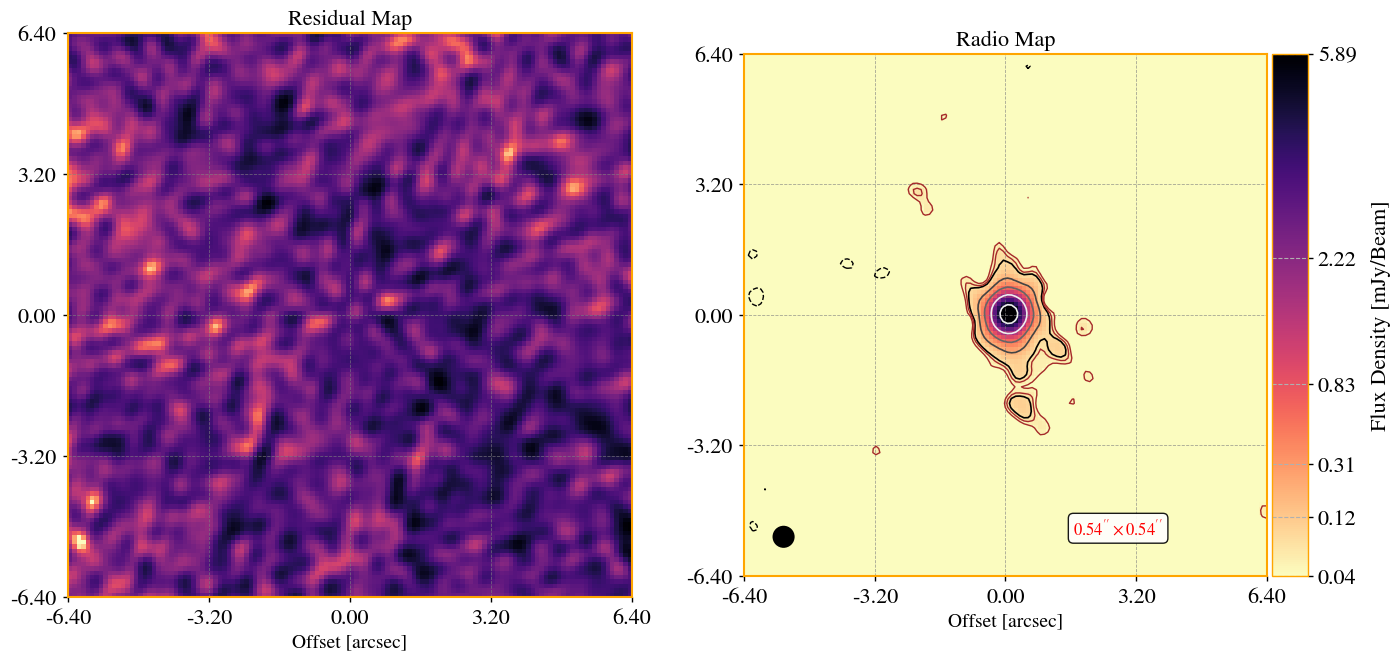

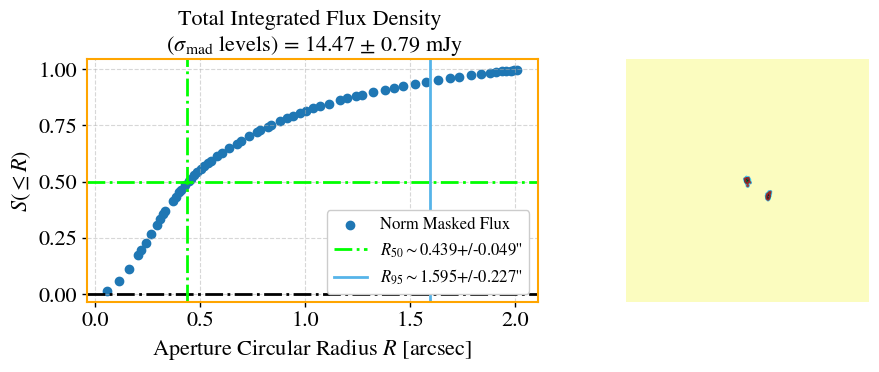

Flux density =  0.014522108149348125
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_S_sf_1024x1024_0.1asec_multiscale__r0.5-0001-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_S_sf_1024x1024_0.1asec_multiscale__r0.5-0001-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 15.94 +/- 1.11 mJy
Fractional error = 0.07
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 15.94 +/- 0.82 mJy
Fractional error = 0.05
-----------------------------------------------------------------


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


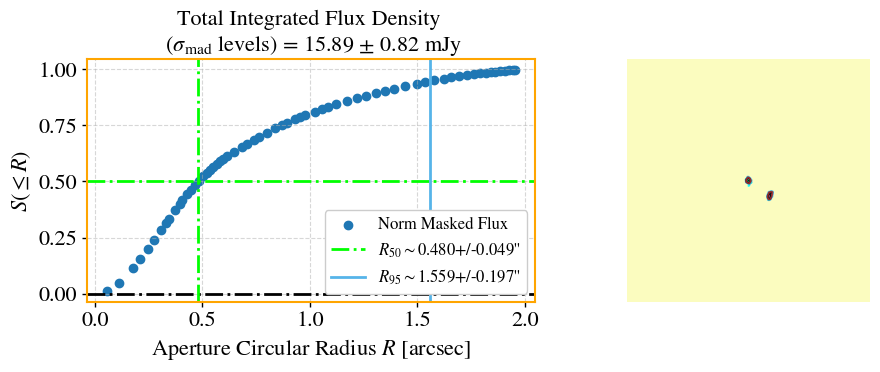

Flux density =  0.01594241029411114
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_S_sf_1024x1024_0.1asec_multiscale__r0.5-0003-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_S_sf_1024x1024_0.1asec_multiscale__r0.5-0003-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 12.30 +/- 1.74 mJy
Fractional error = 0.14
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 12.30 +/- 0.63 mJy
Fractional error = 0.05
-----------------------------------------------------------------


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


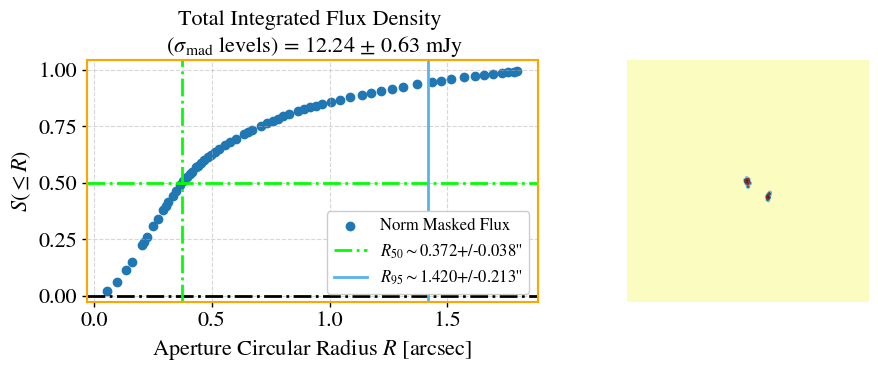

Flux density =  0.012303154822625692
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_S_sf_1024x1024_0.1asec_multiscale__r0.5-0000-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/final_image_nc4_nomfwt_UGC04881_A_S_sf_1024x1024_0.1asec_multiscale__r0.5-0000-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 20.10 +/- 1.61 mJy
Fractional error = 0.08
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 20.10 +/- 1.14 mJy
Fractional error = 0.06
-----------------------------------------------------------------


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


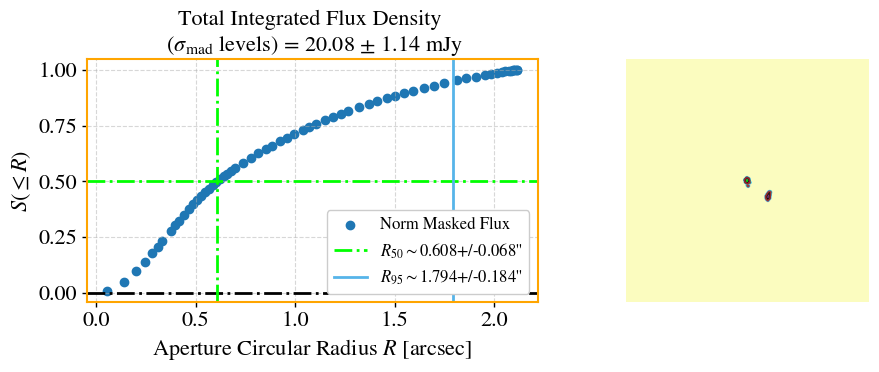

Flux density =  0.02009515426367641
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8406e+00                                    4.43e+03    
       1              4         5.8976e-01      1.25e+00       2.86e+00       3.87e+03    
       2              5         5.7264e-01      1.71e-02       4.85e+00       7.14e+00    
       3              6         5.4505e-01      2.76e-02       5.50e-02       7.01e+00    
       4              7         4.9233e-01      5.27e-02       1.11e-01       6.72e+00    
       5              8         3.9728e-01      9.51e-02       2.29e-01       6.05e+00    
       6              9         2.4568e-01      1.52e-01       4.76e-01       4.60e+00    
       7             10         5.8786e-02      1.87e-01       9.33e-01       1.98e+00    
       8             11         1.2898e-02      4.59e-02       7.21e-01       1.04e+01    
       9             12         1.2894e-02      3.89e-

100%|██████████| 5000/5000 [00:21<00:00, 236.26it/s]


{'A1': {'best': 15.165874304242873, 'lower_bound': 14.757649905209831, 'upper_bound': 15.57272979949936, 'lower': 0.40822439903304186, 'upper': 0.4068554952564867}, 'alpha': {'best': -0.9070528667858279, 'lower_bound': -1.0485022924134073, 'upper_bound': -0.7647827746278815, 'lower': 0.14144942562757945, 'upper': 0.1422700921579464}}
(100000, 2)
++==>> Parameter Results (MCMC sampling).
++==>> Parameter Results (from least-squares fit).
[[Variables]]
    A1:     15.2160537 +/- 0.26683672 (1.75%) (init = 15.21605)
    alpha: -0.92220099 +/- 0.08228097 (8.92%) (init = -0.922201)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, alpha) = 0.430
---------------------------------------------
------------ RESTORING BEAM SIZE ------------
                0.542 arcec            
---------------------------------------------


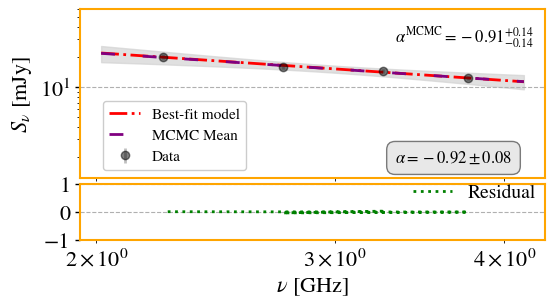

<Figure size 600x400 with 0 Axes>

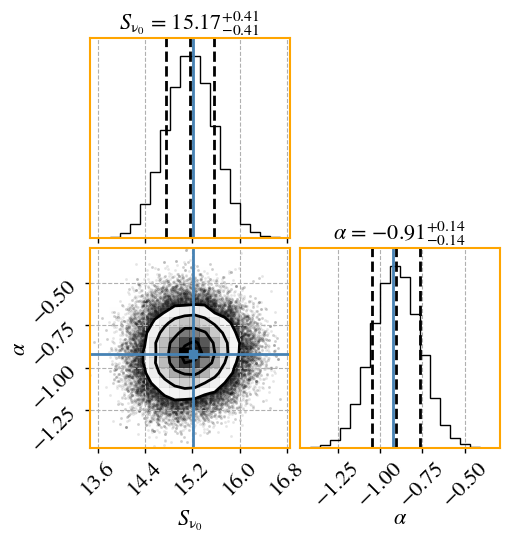

In [25]:
for ROBUST in [0.5]:
    # prefix = 'final_image_for_spidx_cb_bs_0.05asec'
    prefix = f"final_image_nc{n_subimages}_nomfwt"
    image_list,image_statistics,Omaj = \
        mlibs.run_wsclean(vis, robust=ROBUST,
                    imsize=int(1024*1), 
                    imsizey=int(1024*1), 
                    # opt_args= "' -no-mf-weighting '",
                    # opt_args= "' -circular-beam -beam-size 0.05asec '",
                    cell='0.1asec',
                    savemodel = False,
                    base_name=prefix,
                    nsigma_automask='3.0',
                    nsigma_autothreshold='1.0',
                    quiet=True,
                    nc=n_subimages,
                    with_multiscale=True,
                    # scales='0,40,120,240',
                    scales='None',
                    datacolumn='DATA',
                    uvtaper=[''],
                    niter=100000)

 >> Imaging script path: /mnt/ext10TB/GitHub/morphen/morphen
  0.5
Using mtmfs method.
uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_S_sf_uvsub_1024x1024_0.1asec_multiscale__r0.5
 ++==>> Command to be executed by Singularity > WSClean: 
singularity exec --nv --bind /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/:/mnt /nvme1/scratch/lucatelli/apps/wsclean3.4-idg-everybeam-eMERLIN_portable.sif mpirun -np 8 wsclean-mp -name /mnt/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_S_sf_uvsub_1024x1024_0.1asec_multiscale__r0.5 -size 1024 1024 -scale 0.1asec  -mgain 0.5 -gain 0.1 -nmiter 500  -niter 100000 -weight briggs 0.5  -auto-mask 3.0  -auto-threshold 1.0  -multiscale  -multiscale-scale-bias 0.75 -multiscale-gain 0.05  -multiscale-max-scales 6   -deconvolution-threads 16 -j 16 -parallel-reordering 16 -weighting-rank-filter 3 -weighting-rank-filter-size 128 -gridder wgridder -wstack-nwlayers-factor 3 -wgridder-accuracy 1e-7 -no-mf-weighting -channels-out 4 -

No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified
Invalid MIT-MAGIC-COOKIE-1 key

Node 1, PID 35196 on canopus.jb.man.ac.uk
Node 5, PID 35200 on canopus.jb.man.ac.uk
Node 4, PID 35199 on canopus.jb.man.ac.uk
Node 6, PID 35201 on canopus.jb.man.ac.uk
Node 7, PID 35202 on canopus.jb.man.ac.uk
Node 0, PID 35195 on canopus.jb.man.ac.uk
Node 2, PID 35197 on canopus.jb.man.ac.uk
Node 3, PID 35198 on canopus.jb.man.ac.uk
2025-Feb-15 17:00:05.288650 Process 0 finished.
2025-Feb-15 17:00:05.288667 Process 4 finished.
2025-Feb-15 17:00:05.288674 Process 6 finished.
2025-Feb-15 17:00:05.288688 Process 7 finished.
2025-Feb-15 17:00:05.288664 Process 5 finished.
2025-Feb-15 17:00:05.288794 Process 1 finished.
2025-Feb-15 17:00:05.288846 Process 3 finished.
2025-Feb-15 17:00:05.288872 Process 2 finished.
 ++==>> Exec time cleaning = 155.7 s


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: invalid value encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)


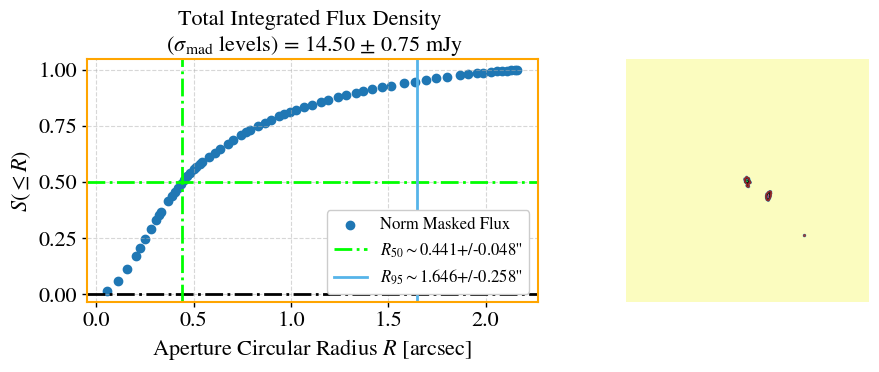

Using residual map as RMS estimator: /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_S_sf_uvsub_1024x1024_0.1asec_multiscale__r0.5-MFS-residual.fits
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_S_sf_uvsub_1024x1024_0.1asec_multiscale__r0.5-0002-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_S_sf_uvsub_1024x1024_0.1asec_multiscale__r0.5-0002-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 14.14 +/- 0.84 mJy
Fractional error = 0.06
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 14.14 +/- 0.72 mJy
Fractional er

/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


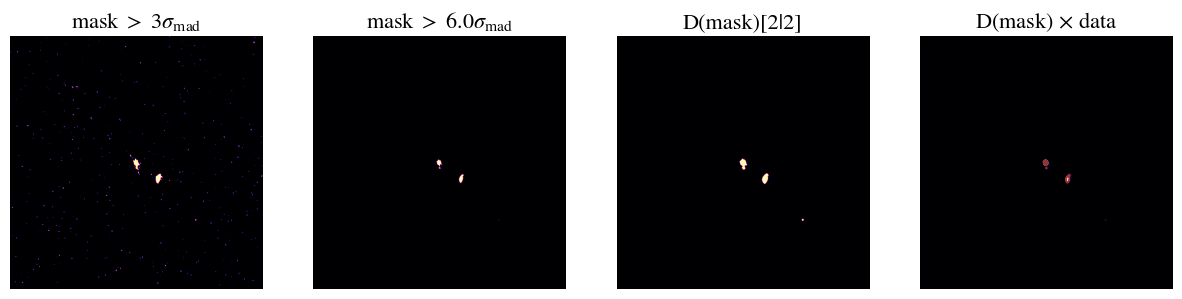

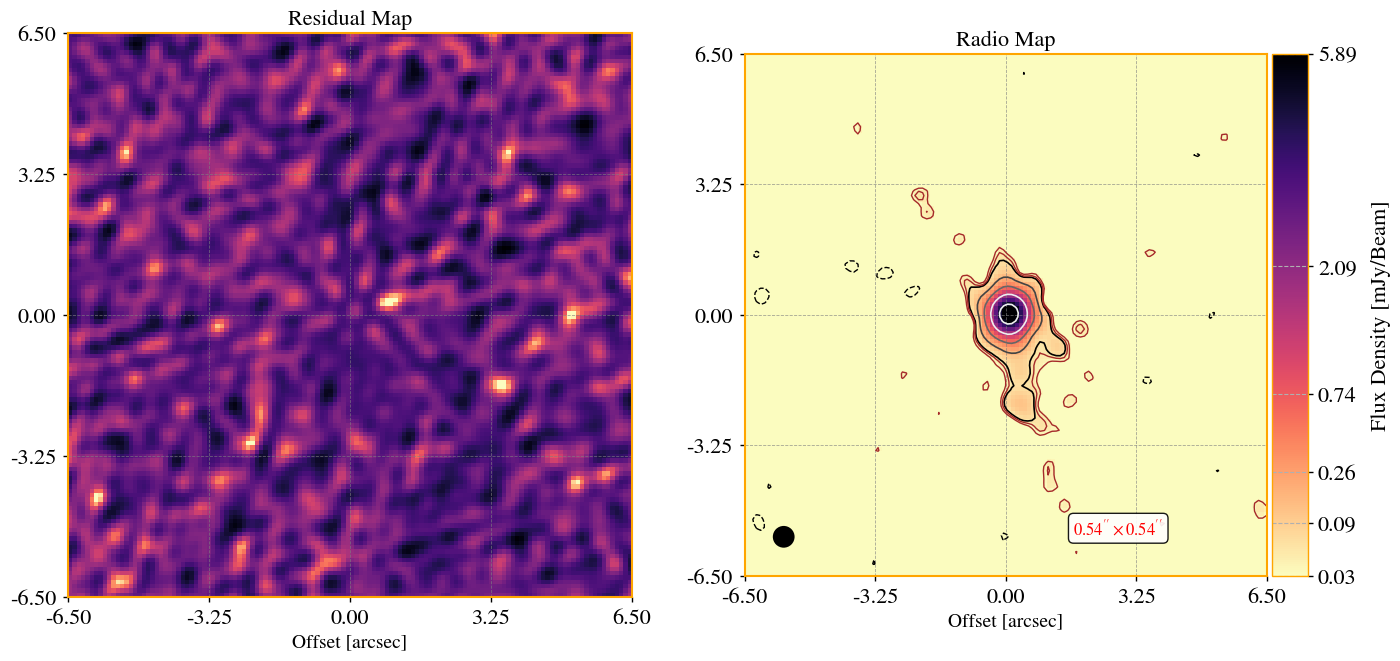

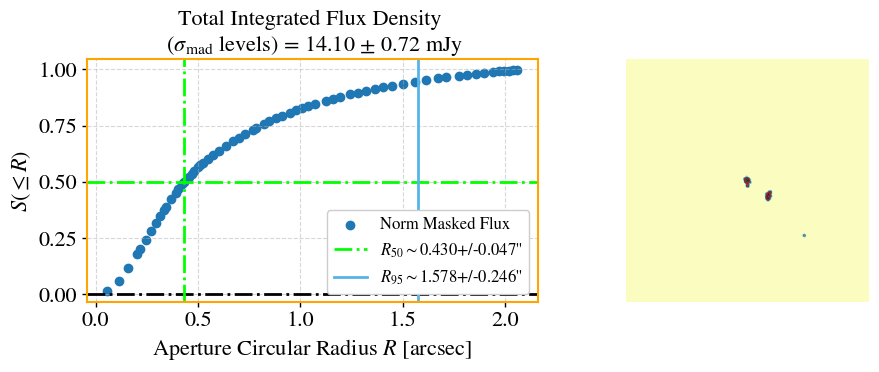

Flux density =  0.014138338434183727
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_S_sf_uvsub_1024x1024_0.1asec_multiscale__r0.5-0003-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_S_sf_uvsub_1024x1024_0.1asec_multiscale__r0.5-0003-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 12.63 +/- 1.68 mJy
Fractional error = 0.13
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 12.63 +/- 0.69 mJy
Fractional error = 0.05
-----------------------------------------------------------------


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


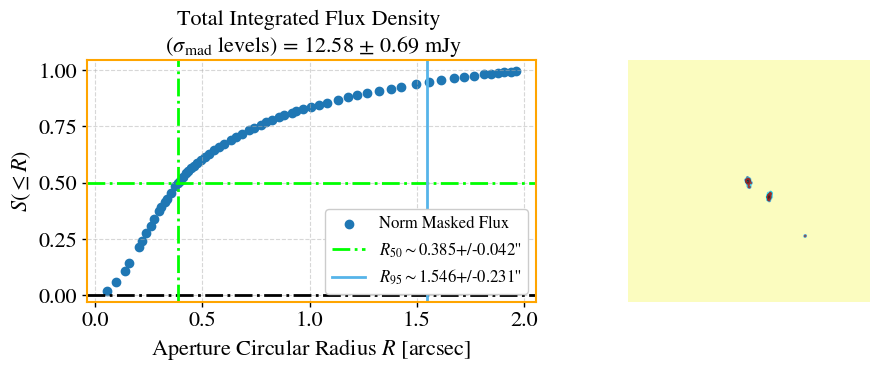

Flux density =  0.012634385181432008
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_S_sf_uvsub_1024x1024_0.1asec_multiscale__r0.5-0000-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_S_sf_uvsub_1024x1024_0.1asec_multiscale__r0.5-0000-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 19.28 +/- 1.38 mJy
Fractional error = 0.07
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 19.28 +/- 0.98 mJy
Fractional error = 0.05
-----------------------------------------------------------------


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


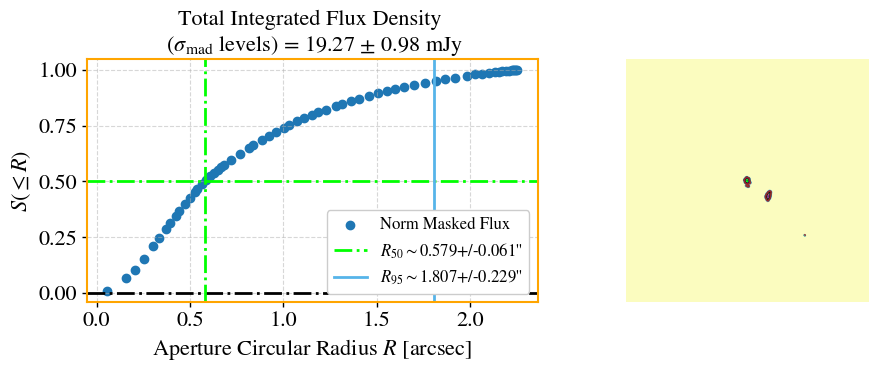

Flux density =  0.019279615147981755
++>> Computing flux density on sub-band image  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_S_sf_uvsub_1024x1024_0.1asec_multiscale__r0.5-0001-image.fits
++>> Associated sub-band  residual image is  /mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/UGC04881/imaging_final/uvsub_clean_image_final_nc4_nomfwt_UGC04881_A_S_sf_uvsub_1024x1024_0.1asec_multiscale__r0.5-0001-residual.fits
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 16.23 +/- 1.11 mJy
Fractional error = 0.07
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 16.23 +/- 0.82 mJy
Fractional error = 0.05
-----------------------------------------------------------------


/mnt/ext10TB/GitHub/reproducibility/LIRGI/uv_analysis/UGC04881/../../../../morphen/morphen/fit_ellipse.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs(xr**2/a**2 + yr**2/b**2 - 1.0)
/raid1/scratch/lucatelli/apps/miniconda3/envs/casa6/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


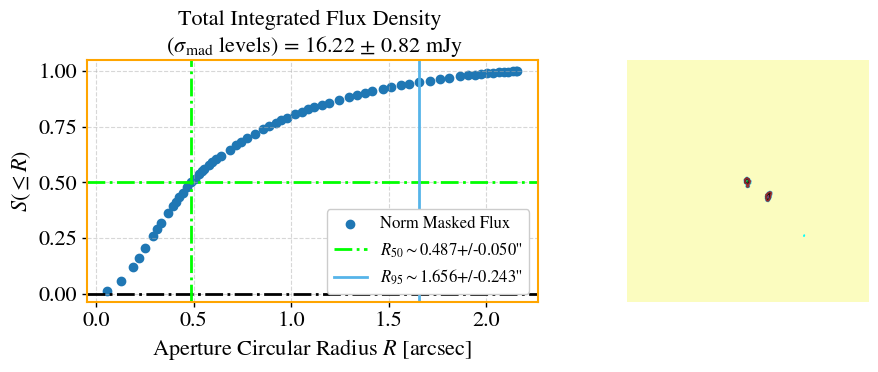

Flux density =  0.016228825961745644
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7373e+00                                    4.45e+03    
       1              4         4.9348e-01      1.24e+00       2.86e+00       3.75e+03    
       2              5         3.7057e-01      1.23e-01       4.18e+00       5.84e+00    
       3              6         3.4620e-01      2.44e-02       5.20e-02       5.70e+00    
       4              7         3.0035e-01      4.59e-02       1.06e-01       5.40e+00    
       5              8         2.2058e-01      7.98e-02       2.20e-01       4.69e+00    
       6              9         1.0488e-01      1.16e-01       4.64e-01       3.15e+00    
       7             10         2.5620e-03      1.02e-01       9.17e-01       4.42e-01    
       8             11         1.8865e-04      2.37e-03       1.60e-01       3.04e-03    
       9             12         1.8843e-04      2.17e

100%|██████████| 5000/5000 [00:18<00:00, 267.04it/s]


{'A1': {'best': 15.141600124720757, 'lower_bound': 14.858754425072691, 'upper_bound': 15.424204041518335, 'lower': 0.2828456996480657, 'upper': 0.28260391679757824}, 'alpha': {'best': -0.8195118908983425, 'lower_bound': -0.9116033059308136, 'upper_bound': -0.7275630637069095, 'lower': 0.09209141503247109, 'upper': 0.09194882719143305}}
(100000, 2)
++==>> Parameter Results (MCMC sampling).
++==>> Parameter Results (from least-squares fit).
[[Variables]]
    A1:     15.1455562 +/- 0.03187008 (0.21%) (init = 15.14556)
    alpha: -0.82101755 +/- 0.01011323 (1.23%) (init = -0.8210176)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, alpha) = 0.363
---------------------------------------------
------------ RESTORING BEAM SIZE ------------
                0.542 arcec            
---------------------------------------------


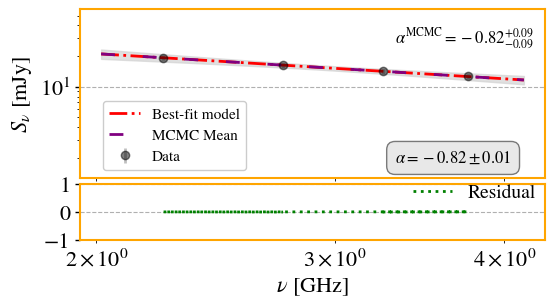

<Figure size 600x400 with 0 Axes>

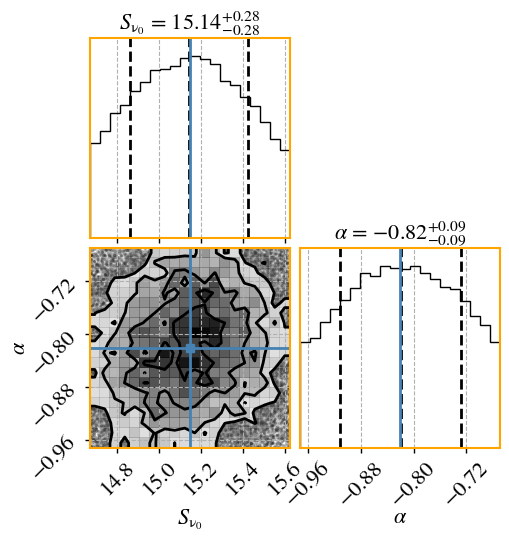

In [26]:
for ROBUST in [0.5]:
    # prefix = 'final_image_for_spidx_cb_bs_0.05asec'
    prefix = f"uvsub_clean_image_final_nc{n_subimages}_nomfwt"
    image_list,image_statistics,Omaj = \
        mlibs.run_wsclean(uv_sub_vis, robust=ROBUST,
                    imsize=int(1024*1), 
                    imsizey=int(1024*1), 
                    # opt_args= "' -no-mf-weighting '",
                    # opt_args= "' -circular-beam -beam-size 0.05asec '",
                    cell='0.1asec',
                    savemodel = False,
                    base_name=prefix,
                    nsigma_automask='3.0',
                    nsigma_autothreshold='1.0',
                    quiet=True,
                    nc=n_subimages,
                    with_multiscale=True,
                    # scales='0,40,120,240',
                    scales='None',
                    datacolumn='DATA',
                    uvtaper=[''],
                    niter=100000)

In [ ]:
plotms(vis=uv_sub_vis,xaxis='uvwave',yaxis='amp',avgchannel='9999',avgtime='9999',correlation='RR',avgantenna=True)

Qt: Session management error: Authentication Rejected, reason : None of the authentication protocols specified are supported and host-based authentication failed
2024-12-24 13:01:25	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 128 for SPW 0 is smaller than specified chanbin 9999
2024-12-24 13:01:25	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 128 for SPW 0
2024-12-24 13:01:25	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 128 for SPW 1 is smaller than specified chanbin 9999
2024-12-24 13:01:25	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 128 for SPW 1
2024-12-24 13:01:25	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 128 for SPW 2 is smaller than specified chanbin 9999
2024-12-24 13:01:25	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 128 for SPW 2
2024-12-24 13:01:25	WARN	MSTransformManager::initDataSelectionParams	Number of 

2024-11-05 17:31:48	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 0 is smaller than specified chanbin 9999
2024-11-05 17:31:48	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 0
2024-11-05 17:31:48	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 1 is smaller than specified chanbin 9999
2024-11-05 17:31:48	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 1
2024-11-05 17:31:48	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 2 is smaller than specified chanbin 9999
2024-11-05 17:31:48	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 2
2024-11-05 17:31:48	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 3 is smaller than specified chanbin 9999
2024-11-05 17:31:48	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SP

In [27]:
plotms(vis=uv_sub_vis,xaxis='uvwave',yaxis='amp',avgchannel='9999',avgtime='9999',
       correlation='RR',avgantenna=False,
       customsymbol=True,symbolsize=1,plotindex=0, clearplots=True,
       symbolcolor='black', symbolshape='circle'
       )
plotms(vis=vis,xaxis='uvwave',yaxis='amp',avgchannel='9999',avgtime='9999',
       correlation='RR',avgantenna=False,
       customsymbol=True,symbolsize=1,plotindex=1, clearplots=False,
       symbolcolor='purple', symbolshape='diamond'
       )

2025-02-15 17:01:06	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 0 is smaller than specified chanbin 9999
2025-02-15 17:01:06	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 0
2025-02-15 17:01:06	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 1 is smaller than specified chanbin 9999
2025-02-15 17:01:06	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 1
2025-02-15 17:01:06	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 2 is smaller than specified chanbin 9999
2025-02-15 17:01:06	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SPW 2
2025-02-15 17:01:06	WARN	MSTransformManager::initDataSelectionParams	Number of selected channels 64 for SPW 3 is smaller than specified chanbin 9999
2025-02-15 17:01:06	WARN	MSTransformManager::initDataSelectionParams+	Setting chanbin to 64 for SP